# DARC(Domain Adaptation for Regression under conditional Distribution shift)
##### (1) Siamese NN (xi -> Feature Extractor1 -> fi & xj -> Feature Extractor2 -> fj) -> psp_loss = ||yi-yj|-|fi - fj|2| 
##### (2) fi -> Regressor train

### 실험세팅은 우리 CDMR이랑 동일하게 함
#### 과연 DARC로도 우리 실험 세팅에서 잘 될까?
#### Labeled Source 100개 & Labeled Target 10개 (DARC는 supervised method이기에 unlabeled는 사용 못함!)

In [1]:
# Toy data 생성 및 시각화를 위한 라이브러리
import pandas as pd
import seaborn as sns
import torch
import numpy as np
from torch.distributions.normal import Normal
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.
import torch.nn.functional as F  
import numpy as np
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import copy
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from random import randint   
from torch.utils.data import RandomSampler

#### DataFrame -> Pytorch 사용을 위해 형태 변환

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import torch
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.
import torch.nn.functional as F  
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import os

class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

#### Source domain Feature Extractor : input feature(dim=4)-쌍둥이 -(8dim weight & bias & ReLU)> embedded feature(dim=2)

In [36]:
import random
bn = 4
df_s =pd.read_csv("df_s.csv")
df_t =pd.read_csv("df_t.csv")
df_s_true =pd.read_csv("df_s_true.csv")
df_t_true =pd.read_csv("df_t_true.csv")
df_t_labeled =pd.read_csv("df_t_labeled.csv")

x_s = np.array(df_s['X']).tolist()
x_t = np.array(df_t['X']).tolist()
x_t_labeled = np.array(df_t_labeled['X']).tolist()
y_s = np.array(df_s['Y']).tolist()
y_t = np.array(df_t['Y']).tolist()
y_t_labeled = np.array(df_t_labeled['Y']).tolist()
y_s_true = np.array(df_s_true['Y']).tolist()
y_t_true = np.array(df_t_true['Y']).tolist()

<Axes: xlabel='X', ylabel='Y'>

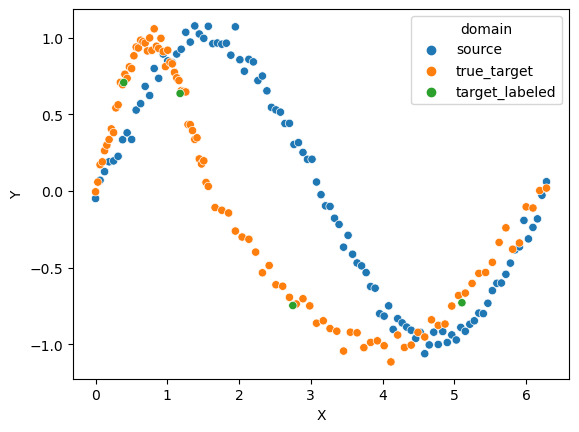

In [37]:
data_s = [[x_s[i],y_s[i],'source'] for i in range(len(x_s))]
df_s = pd.DataFrame(data_s, columns=['X','Y','domain'])


data_s_true = [[x_s[i],y_s_true[i],'source'] for i in range(len(x_s))]
df_s_true = pd.DataFrame(data_s_true, columns=['X','Y','domain'])
df_s_true = df_s_true.sort_values('X')

data_t = [[x_t[i],y_t[i],'true_target'] for i in range(len(x_t))]
df_t = pd.DataFrame(data_t, columns=['X','Y','domain'])

data_t_true = [[x_t[i],y_t_true[i],'true_target'] for i in range(len(x_t))]
df_t_true = pd.DataFrame(data_t_true, columns=['X','Y','domain'])

df_t_true = df_t_true.sort_values('X')
data_t_labeled = [[x_t_labeled[i],y_t_labeled[i],'target_labeled'] for i in range(len(x_t_labeled))]
df_t_labeled = pd.DataFrame(data_t_labeled, columns=['X','Y','domain'])

sns.scatterplot(data=pd.concat([df_s, df_t, df_t_labeled]), x= 'X', y='Y', hue='domain')

In [38]:
df1 = df_s.copy()
df2 = df_t.copy()
df3 = df_t_labeled.copy()
df1_true = df_s_true.copy()
df2_true = df_t_true.copy()

In [39]:
x_s = torch.tensor(x_s).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(x_t).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(x_t_labeled).reshape(-1,1).type(torch.float32)

In [40]:
y_s = torch.tensor(y_s).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(y_t).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(y_t_labeled).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(y_s_true).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(y_t_true).reshape(-1,1).type(torch.float32)

In [41]:
source_X = np.array(x_s)
source_Y = np.array(y_s)

X_train_source, X_test_source, Y_train_source, Y_test_source = train_test_split(source_X, source_Y, test_size=0.3)

# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train_source, Y_train_source)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=64, shuffle=True)

testsets = TensorData(X_test_source, Y_test_source)
testloader = torch.utils.data.DataLoader(testsets, batch_size=64, shuffle=False)

In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [43]:
class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.fe = nn.Linear(3, 256, bias=True)
        self.mid1 = nn.Linear(256,256,bias=True)
        self.mid3 = nn.Linear(256,256,bias=True)
        self.mid2 = nn.Linear(256, 1,bias=True)
        self.relu = nn.ReLU()


    def forward_one(self, x):
        x = self.fe(x)
        x = self.relu(x)
        x = self.mid1(x)
        x = self.relu(x)
        x = self.mid3(x)
        x = self.relu(x)
        x = self.mid2(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
       

        return _, out1, out2
 

#### Labeling 된 target domain data는 전체 target domain data의 10% : 200개

In [44]:
df1['d1']=1
df1['d2']=0
df2['d1']=0
df2['d2']=1
df3['d1']=0
df3['d2']=1

In [45]:
total_df = pd.concat([df1,df3])
total_df

,X,Y,domain,d1,d2
0,0.000000,-0.049418,source,1,0
1,0.062832,0.069684,source,1,0
2,0.125664,0.126021,source,1,0
3,0.188496,0.190041,source,1,0
4,0.251327,0.195839,source,1,0
...,...,...,...,...,...
100,6.283185,0.060290,source,1,0
0,0.392699,0.706819,target_labeled,0,1
1,1.178097,0.635876,target_labeled,0,1
2,2.748894,-0.747228,target_labeled,0,1


#### DARC 진행

In [13]:
device = 'cpu'
# Generate the Model
net = Siamese().to(device)

# Set the Training Parameters
lr = 1e-3

import copy
best_model = copy.deepcopy(net)
epochs = 10000
best_loss = 10000000
bn = 30
b_n = 1
optimizer = optim.Adam(net.parameters(), lr=lr)
net.train()


for t in range(epochs):
    tt = torch.empty(1,3)
    losss = 0
    print(f'----- Epoch {t+1} -----')
    for tt in range(b_n):
        sample1 = total_df.sample(bn)
        sample2 = total_df.sample(bn)
        xi = torch.tensor(sample1[['X','d1','d2']].values.tolist())
        xj = torch.tensor(sample2[['X','d1','d2']].values.tolist())
        yi = torch.tensor(sample1['Y'].values.tolist())
        yj = torch.tensor(sample2['Y'].values.tolist())

        
        optimizer.zero_grad()
        y_dist = torch.abs(yi - yj)
        _,z1,z2 = net(xi, xj)
        distance = F.pairwise_distance(z1,z2,keepdim=True).squeeze()
        
        if t % 500 == 0:
            tmp = torch.stack([y_dist, distance])
            tt = torch.cat([tmp])
        
        psp_loss = torch.abs(y_dist - distance).mean()    
        losss += psp_loss
        psp_loss.backward()
        optimizer.step()
        
    print(f"loss : {losss.item()}")
    if best_loss > losss:
        best_loss = losss
        best_model = copy.deepcopy(net)
    
    

# for name, child in net.named_children():
#     for item in child.parameters():
#         print(f"{name} parameter 개수 : {len(item)}")
#         print(f"{name} parameter 값 : {item}")
    

----- Epoch 1 -----
loss : 0.7053635716438293
----- Epoch 2 -----
loss : 0.5752944946289062
----- Epoch 3 -----
loss : 0.40684542059898376
----- Epoch 4 -----
loss : 0.4874715805053711
----- Epoch 5 -----
loss : 0.38344860076904297
----- Epoch 6 -----
loss : 0.3765561282634735
----- Epoch 7 -----
loss : 0.4384406507015228
----- Epoch 8 -----
loss : 0.4078308045864105
----- Epoch 9 -----
loss : 0.2628779411315918
----- Epoch 10 -----
loss : 0.3585614562034607
----- Epoch 11 -----
loss : 0.3715544641017914
----- Epoch 12 -----
loss : 0.41320356726646423
----- Epoch 13 -----
loss : 0.29549136757850647
----- Epoch 14 -----
loss : 0.398134708404541
----- Epoch 15 -----
loss : 0.36386439204216003
----- Epoch 16 -----
loss : 0.34217196702957153
----- Epoch 17 -----
loss : 0.5060559511184692
----- Epoch 18 -----


loss : 0.3608222007751465
----- Epoch 19 -----
loss : 0.4165005087852478
----- Epoch 20 -----
loss : 0.3062683641910553
----- Epoch 21 -----
loss : 0.32235971093177795
----- Epoch 22 -----
loss : 0.35390087962150574
----- Epoch 23 -----
loss : 0.37485626339912415
----- Epoch 24 -----
loss : 0.3678099513053894
----- Epoch 25 -----
loss : 0.4175390303134918
----- Epoch 26 -----
loss : 0.3061951994895935
----- Epoch 27 -----
loss : 0.3563680052757263
----- Epoch 28 -----
loss : 0.37557950615882874
----- Epoch 29 -----
loss : 0.2945195436477661
----- Epoch 30 -----
loss : 0.28482356667518616
----- Epoch 31 -----
loss : 0.27339881658554077
----- Epoch 32 -----
loss : 0.45086875557899475
----- Epoch 33 -----
loss : 0.47692251205444336
----- Epoch 34 -----
loss : 0.3924730122089386
----- Epoch 35 -----
loss : 0.3530455231666565
----- Epoch 36 -----
loss : 0.27998268604278564
----- Epoch 37 -----
loss : 0.2713773846626282
----- Epoch 38 -----
loss : 0.3594869077205658
----- Epoch 39 -----
loss

In [14]:
torch.save(best_model,"./best_4shot_DARC.pt")

In [46]:
print(best_loss)

tensor(0.0271, grad_fn=<AddBackward0>)


In [47]:
source_x = torch.tensor(df1[['X','d1','d2']].values.tolist())
target_x = torch.tensor(df2[['X','d1','d2']].values.tolist())
latent_source = best_model.forward(source_x, target_x)[1]
latent_target = best_model.forward(source_x, target_x)[2]

### 최종적으로 Embedded된 feature들 : y값 분포가 동일하므로, 완전히 1ㄷ1 mapping되면 됨!
#### but... 그렇지 못하네...

### Regressor 학습 -> 성능 어느 정도는 뭐...(비슷한 곳에 mapping된 것들도 있으므로) 근데 그리 좋지는 못함...

In [49]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

MLPR = MLPRegressor(hidden_layer_sizes=(100), validation_fraction=0.1)
# MLPR = LinearRegression()
source_x = torch.tensor(df1[['X','d1','d2']].values.tolist())
target_x = torch.tensor(df3[['X','d1','d2']].values.tolist())
latent_source = best_model.forward(source_x, source_x)[1]
latent_target = best_model.forward(target_x, target_x)[2]
df_s = pd.DataFrame(latent_source.tolist(),columns=['f1'])
df_t = pd.DataFrame(latent_target.tolist(),columns=['f1'])
df_s['from']='source'
df_t['from']='target'
df_s['y']=df1_true['Y']
#df_t['y']=df2[0]
df_total = pd.concat([df_s], axis=0)

MLPR.fit(df_total[['f1']],df_total['y'])
print("train R2: ", MLPR.score(df_s[['f1']],df_s['y']))

target_x = torch.tensor(df2[['X','d1','d2']].values.tolist())
latent_target = best_model.forward(target_x, target_x)[2]
df_t = pd.DataFrame(latent_target.tolist(),columns=['f1'])
df_t['from']='target'
df_t['y']=df2_true['Y']

print("test R2: ", MLPR.score(df_t[['f1']],df_t['y']))

train R2:  0.9949725367001954
test R2:  0.9229423213389568


In [50]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_t['y'], MLPR.predict(df_t[['f1']]))


0.03814736567378375

In [51]:
mean_squared_error(df_s['y'], MLPR.predict(df_s[['f1']]))

0.0024888432177250864

<Axes: xlabel='X', ylabel='Y'>

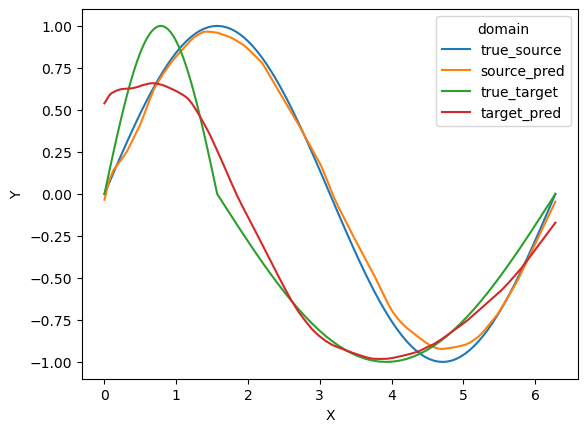

In [53]:
df_s_plot = pd.concat([df1['X'],pd.DataFrame(MLPR.predict(df_s[['f1']]),columns=['Y'])],axis=1)
df_s_plot['domain'] = 'source_pred'
df_s_plot = df_s_plot.sort_values('X')

df_s_label = pd.concat([df1['X'],df1_true['Y']],axis=1)
df_s_label['domain'] = 'true_source'
df_s_label = df_s_label.sort_values('X')

df_t_plot = pd.concat([df2['X'],pd.DataFrame(MLPR.predict(df_t[['f1']]),columns=['Y'])],axis=1)
df_t_plot['domain'] = 'target_pred'
df_t_plot = df_t_plot.sort_values('X')

df_t_label = pd.concat([df2['X'],df2_true['Y']],axis=1)
df_t_label['domain'] = 'true_target'
df_t_label = df_t_label.sort_values('X')

df_total_plot = pd.concat([df_s_label,df_s_plot,df_t_label,df_t_plot])
sns.lineplot(data = df_total_plot, x = 'X', y='Y', hue = 'domain')

In [55]:
df_total_plot.to_csv("./df_total_plot_4shot_DARC.csv",index=False)

In [21]:
print("0928 12:00 현재 시각 ? 끝까지 다 돌림 !")

0928 12:00 현재 시각 ? 끝까지 다 돌림 !
